In [1]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0


     |████████████████████████████████| 61kB 3.2MB/s 
     |███████████████████████████████▌| 834.1MB 1.5MB/s eta 0:00:08tcmalloc: large alloc 1147494400 bytes == 0x659a2000 @  0x7f8840f46615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
import collections
from d2l import mxnet as d2l
import math
from mxnet import autograd, gluon, init, npx
from mxnet.gluon import nn
import os
import pandas as pd
import shutil
import time

npx.set_np()

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# If you use the full dataset downloaded for the Kaggle competition, set
# `demo` to False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

In [ ]:
#@save
def read_csv_labels(fname):
    """Read fname to return a name to label dictionary."""
    with open(fname, 'r') as f:
        # Skip the file header line (column name)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

# training examples: 1000
# classes: 10


In [ ]:
#@save
def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    # The number of examples of the class with the least examples in the
    # training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        # Copy to train_valid_test/train_valid with a subfolder per class
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            # Copy to train_valid_test/valid
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # Copy to train_valid_test/train
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

In [ ]:
#@save
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

In [ ]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [ ]:
batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [ ]:
transform_train = gluon.data.vision.transforms.Compose([
    # Magnify the image to a square of 40 pixels in both height and width
    gluon.data.vision.transforms.Resize(40),
    # Randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then shrink it to a square of 32 pixels in both height and
    # width
    gluon.data.vision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor(),
    # Normalize each channel of the image
    gluon.data.vision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                           [0.2023, 0.1994, 0.2010])])

In [ ]:
transform_test = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                           [0.2023, 0.1994, 0.2010])])

In [ ]:
train_ds, valid_ds, train_valid_ds, test_ds = [
    gluon.data.vision.ImageFolderDataset(
        os.path.join(data_dir, 'train_valid_test', folder))
    for folder in ['train', 'valid', 'train_valid', 'test']]

In [ ]:
train_iter, train_valid_iter = [gluon.data.DataLoader(
    dataset.transform_first(transform_train), batch_size, shuffle=True,
    last_batch='discard') for dataset in (train_ds, train_valid_ds)]

valid_iter = gluon.data.DataLoader(
    valid_ds.transform_first(transform_test), batch_size, shuffle=False,
    last_batch='discard')

test_iter = gluon.data.DataLoader(
    test_ds.transform_first(transform_test), batch_size, shuffle=False,
    last_batch='keep')

In [ ]:
class Residual(nn.HybridBlock):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1,
                               strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1,
                                   strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def hybrid_forward(self, F, X):
        Y = F.npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.npx.relu(Y + X)

In [ ]:
def resnet18(num_classes):
    net = nn.HybridSequential()
    net.add(nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
            nn.BatchNorm(), nn.Activation('relu'))

    def resnet_block(num_channels, num_residuals, first_block=False):
        blk = nn.HybridSequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(Residual(num_channels))
        return blk

    net.add(resnet_block(64, 2, first_block=True),
            resnet_block(128, 2),
            resnet_block(256, 2),
            resnet_block(512, 2))
    net.add(nn.GlobalAvgPool2D(), nn.Dense(num_classes))
    return net

In [ ]:
def get_net(devices):
    num_classes = 10
    net = resnet18(num_classes)
    net.initialize(ctx=devices, init=init.Xavier())
    return net

loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(
                net, features, labels.astype('float32'), loss, trainer,
                devices, d2l.split_batch)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpus(net, valid_iter,
                                                   d2l.split_batch)
            animator.add(epoch + 1, (None, None, valid_acc))
    if valid_iter is not None:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}, '
              f'valid acc {valid_acc:.3f}')
    else:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

loss 2.288, train acc 0.128, valid acc 0.163
145.1 examples/sec on [gpu(0), gpu(1)]


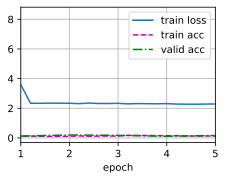

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.1, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net(devices)
net.hybridize()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

loss 2.339, train acc 0.111
145.4 examples/sec on [gpu(0), gpu(1)]


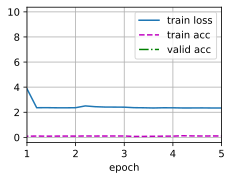

In [ ]:
net, preds = get_net(devices), []
net.hybridize()
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.as_in_ctx(devices[0]))
    preds.extend(y_hat.argmax(axis=1).astype(int).asnumpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('submission.csv', index=False)